In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

from PIL import Image
import glob

In [2]:
#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [3]:
train_dir = 'C:\\users\\will\\ds\\mammo\\train'
valid_dir = 'C:\\users\\will\\ds\\mammo\\validation'
test_dir = 'C:\\users\\will\\ds\\mammo\\test'

img_width, img_height = 75, 75
batch_size = 16
num_epochs = 5
filter_size = (3, 3)
pool_size = (2, 2)
drop_out_dense = 0.5
drop_out_conv = 0.25
padding = 'same'
#learning_rate = 0.02
#decay = learning_rate / (num_epochs - 1)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 39011 images belonging to 2 classes.
Found 8436 images belonging to 2 classes.
Found 8438 images belonging to 2 classes.


In [4]:
#model.add(BatchNormalization())

model = Sequential()

model.add(Conv2D(32, kernel_size=filter_size, activation='relu', input_shape=(img_width, img_height, 1), padding=padding))
model.add(Conv2D(32, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [5]:
SGD = keras.optimizers.SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            #class_weight= {0:.40, 1:.60},
            validation_data = validation_generator)

Epoch 1/5
2439/2439 [==============================] - 37s 15ms/step - loss: 0.3484 - acc: 0.8691 - val_loss: 0.3168 - val_acc: 0.8704
Epoch 2/5
2439/2439 [==============================] - 36s 15ms/step - loss: 0.3087 - acc: 0.8707 - val_loss: 0.2864 - val_acc: 0.8828
Epoch 3/5
2439/2439 [==============================] - 34s 14ms/step - loss: 0.2889 - acc: 0.8814 - val_loss: 0.2650 - val_acc: 0.8893
Epoch 4/5
2439/2439 [==============================] - 34s 14ms/step - loss: 0.2718 - acc: 0.8905 - val_loss: 0.2548 - val_acc: 0.8976
Epoch 5/5
2439/2439 [==============================] - 34s 14ms/step - loss: 0.2640 - acc: 0.8954 - val_loss: 0.2676 - val_acc: 0.8947


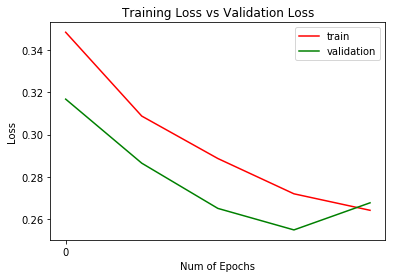

In [6]:
import numpy as np
plt.figure(1)
plt.plot(result.history['loss'],'r')
plt.plot(result.history['val_loss'],'g')
plt.xticks(np.arange(0, num_epochs+1, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [7]:
predict_and_report(train_generator, model)
predict_and_report(validation_generator, model)

Accuracy: 0.8945681987131835
Area Under the Receiver Operating Characteristic Curve: 0.6147394387211955
             precision    recall  f1-score   support

          0       0.90      0.99      0.94     33909
          1       0.85      0.24      0.37      5102

avg / total       0.89      0.89      0.87     39011

Accuracy: 0.8947368421052632
Area Under the Receiver Operating Characteristic Curve: 0.6109106282050147
             precision    recall  f1-score   support

          0       0.90      0.99      0.94      7343
          1       0.85      0.23      0.36      1093

avg / total       0.89      0.89      0.87      8436



In [8]:
model.layers

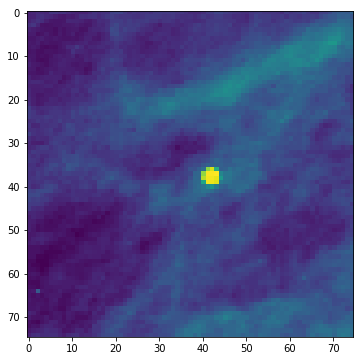

In [9]:
img = Image.open(r'C:\Users\Will\ds\mammo\train\pos\positive2194.jpg')
img = img.resize([img_width, img_height])
img = np.array(img)
plt.imshow(img)
plt.show()

In [10]:
img.shape

(75, 75)

In [11]:
#init = tf.global_variables_initializer()

#with tf.Session() as sess:
    #sess.run(init)

from vis.visualization import visualize_saliency, visualize_cam, overlay, get_num_filters
heatmap = visualize_cam(model,
                        layer_idx=-1, 
                        filter_indices=1,
                        seed_input=img,
                        penultimate_layer_idx=14)

Using TensorFlow backend.


FailedPreconditionError: Attempting to use uninitialized value dense_1/kernel
	 [[Node: dense_1/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/kernel)]]
	 [[Node: gradients/AddN_2/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_388_gradients/AddN_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
get_num_filters(model.layers[-1])